In [1]:
import librosa2
import librosa
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import scipy
import pandas as pd
%matplotlib inline
import os
import csv
import natsort
from openpyxl import load_workbook
import scipy.io

In [2]:
def reverse_mfcc(y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs):

    if S is None:
        S = power_to_db(reverse_melspectrogram(y=y, sr=sr, **kwargs))

    M = scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_mfcc]

    if lifter > 0:
        M *= 1 + (lifter / 2) * np.sin(np.pi * np.arange(1, 1 + n_mfcc, dtype=M.dtype) / lifter)[:, np.newaxis]
        return M
    elif lifter == 0:
        return M
    else:
        raise ParameterError('MFCC lifter={} must be a non-negative number'.format(lifter))

In [3]:
def reverse_melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, win_length=None, window='hann', center=True, pad_mode='reflect', power=2.0, **kwargs):

    S, n_fft = _spectrogram(y=y, S=S, n_fft=n_fft, hop_length=hop_length, power=power,
                            win_length=win_length, window=window, center=center,
                            pad_mode=pad_mode)

    # Build a Mel filter
    mel_basis = filters.mel(sr, n_fft, **kwargs)
    rev_basis = np.flip(mel_basis)

    return np.dot(rev_basis, S)

In [4]:
def _spectrogram(y=None, S=None, n_fft=2048, hop_length=512, power=1, win_length=None, window='hann', center=True, pad_mode='reflect'):

    if S is not None:
        # Infer n_fft from spectrogram shape
        n_fft = 2 * (S.shape[0] - 1)
    else:
        # Otherwise, compute a magnitude spectrogram from input
        S = np.abs(stft(y, n_fft=n_fft, hop_length=hop_length,
                        win_length=win_length, center=center,
                        window=window, pad_mode=pad_mode))**power

    return S, n_fft

In [5]:
def reverse_mel(sr, n_fft, n_mels=128, fmin=0.0, fmax=None, htk=False, norm='slaney', dtype=np.float32):

    if fmax is None:
        fmax = float(sr) / 2

    if norm == 1:
        warnings.warn('norm=1 behavior will change in librosa 0.8.0. '
                      "To maintain forward compatibility, use norm='slaney' instead.",
                      FutureWarning)
    elif norm == np.inf:
        warnings.warn('norm=np.inf behavior will change in librosa 0.8.0. '
                      "To maintain forward compatibility, use norm=None instead.",
                      FutureWarning)

    elif norm not in (None, 1, 'slaney', np.inf):
        raise ParameterError("Unsupported norm={}, must be one of: None, 1, 'slaney', np.inf".format(repr(norm)))

    # Initialize the weights
    n_mels = int(n_mels)
    weights = np.zeros((n_mels, int(1 + n_fft // 2)), dtype=dtype)

    # Center freqs of each FFT bin
    fftfreqs = fft_frequencies(sr=sr, n_fft=n_fft)

    # 'Center freqs' of mel bands - uniformly spaced between limits
    mel_f = reverse_mel_frequencies(n_mels + 2, fmin=fmin, fmax=fmax, htk=htk)

    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, fftfreqs)

    for i in range(n_mels):
        # lower and upper slopes for all bins
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i+2] / fdiff[i+1]

        # .. then intersect them with each other and zero
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    if norm in (1, 'slaney'):
        # Slaney-style mel is scaled to be approx constant energy per channel
        enorm = 2.0 / (mel_f[2:n_mels+2] - mel_f[:n_mels])
        weights *= enorm[:, np.newaxis]


    # Only check weights if f_mel[0] is positive
    if not np.all((mel_f[:-2] == 0) | (weights.max(axis=1) > 0)):
        # This means we have an empty channel somewhere
        warnings.warn('Empty filters detected in mel frequency basis. '
                      'Some channels will produce empty responses. '
                      'Try increasing your sampling rate (and fmax) or '
                      'reducing n_mels.')

    return weights

In [13]:
#admin stuff
# filenames must be of type label_h_*_filenam, where * is a certain impulse response legnth
# e.g. '180_h_10_music-hd-0006'
data_name = 'data6_validation'
IR_lenght = 1000
newFileName = f'D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES3/reverse_Mel_scale/{data_name}_{IR_lenght}ms_R.csv' #don't forget the '.csv'
# newFileLocation = '' #empyt if current folder suffices
readAudioFrom = f'D:/Users/MC/Documents/UNI/MASTER/thesis/AUGMENTED_DATA/{data_name}'
impulseResponseLength = f'h_{IR_lenght}'

In [14]:
#preparing header
# consist of original filename the mean and variance of each Mel frequency bank, the mean and variance of each corrseponding delta and delta-delta
header = 'filename '
for i in range(0, 60):
    header += f' mfcc{i}'
for i in range(0, 60):
    header += f' delta{i}'
for i in range(0, 60):
    header += f' deltaDelta{i}'
header += ' label'
header = header.split()
file = open(newFileName, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [15]:
#reading dataset from csv
data = pd.read_csv(newFileName)
data.head()

,filename,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,...,deltaDelta51,deltaDelta52,deltaDelta53,deltaDelta54,deltaDelta55,deltaDelta56,deltaDelta57,deltaDelta58,deltaDelta59,label


In [16]:
#READING .wav
directions = '0 9 18 27 36 45 54 63 72 81 90 99 108 117 126 135 144 153 162 171 180 189 198 207 216 225 234 243 252 261 270 279 288 297 306 315 324 333 342 351'.split()
for d in directions:
    print(d)
    for filename in os.listdir(f'{readAudioFrom}/{d}'):
        if filename.startswith(f"{d}_{impulseResponseLength}_"):
            #get audio data
            audio_file = f'{readAudioFrom}/{d}/{filename}'
            y,sr = librosa2.load(audio_file, sr=44100)
            
            #get features
            fftWindowSize = 1024                 #~23ms (default:2048 =~46ms @44.1kHz)
            overlapSize = int(fftWindowSize/4)   #ovelap 75%
            numOfMelFilterBanks = 60             #amount of Mel filterbanks
            mfcc = librosa2.feature.reverse_mfcc(y=y, sr=sr, n_mfcc=numOfMelFilterBanks, n_mels=numOfMelFilterBanks, n_fft=fftWindowSize, hop_length=overlapSize)
            delta = librosa.feature.delta(mfcc)
            deltaDelta = librosa.feature.delta(mfcc, order=2)
            
            #write to csv
            to_append = f'{filename} ' 
            #average psd per filterbank and write to file
            for i in mfcc:
                to_append += f' {np.mean(i)}' 
                to_append += f' {np.var(i)}' 
            #average speed
            for j in delta:
                to_append += f' {np.mean(j)}'
                to_append += f' {np.var(j)}'
            #average acceleration
            for k in deltaDelta:
                to_append += f' {np.mean(k)}'
                to_append += f' {np.var(k)}'
            #write label to file
            to_append += f' {d}'
            file = open(newFileName, 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

0
9
18
27
36
45
54
63
72
81
90
99
108
117
126
135
144
153
162
171
180
189
198
207
216
225
234
243
252
261
270
279
288
297
306
315
324
333
342
351


In [10]:
print(mfcc.shape)
for i in mfcc:
    for ii in i:
        print(ii)

(40, 862)
-490.16003
-479.52408
-473.43616
-471.81207
-471.74088
-471.71463
-470.7767
-470.57248
-470.77393
-470.45477
-471.0021
-471.55365
-471.47232
-471.36084
-471.17554
-471.4556
-470.98413
-470.99008
-470.8334
-470.42294
-469.6327
-469.20734
-468.5877
-467.58524
-466.31027
-466.06412
-467.0526
-466.88788
-466.91986
-467.10858
-468.19742
-469.97485
-470.44525
-470.4097
-470.24887
-470.5608
-470.41403
-471.1092
-471.3259
-471.10718
-471.33115
-471.51877
-471.29425
-470.86035
-470.58728
-470.7394
-471.4949
-471.51343
-470.79712
-470.9878
-471.31287
-471.24973
-470.0616
-467.591
-465.31094
-464.17368
-464.49564
-463.2627
-463.29236
-464.9352
-466.868
-460.38068
-435.9208
-424.40863
-430.68192
-422.8747
-406.62442
-397.68356
-394.52524
-395.68777
-398.69022
-401.96924
-402.70447
-404.7678
-406.05255
-408.0257
-409.96298
-411.2494
-412.311
-412.7881
-413.21997
-411.91196
-412.21976
-413.9283
-414.58118
-415.3406
-417.84232
-420.5294
-421.43878
-426.4514
-431.80667
-432.28656
-432.8667
-

In [17]:
#reading dataset from csv
data = pd.read_csv(newFileName)
data.head()

,filename,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,...,deltaDelta34471,deltaDelta34472,deltaDelta34473,deltaDelta34474,deltaDelta34475,deltaDelta34476,deltaDelta34477,deltaDelta34478,deltaDelta34479,label
0,0_h_1000_101-126860-0049.wav,-490.160034,-479.524078,-473.436157,-471.812073,-471.740875,-471.714630,-470.776703,-470.572479,-470.773926,...,0.162921,0.052074,-0.043956,-0.157890,-0.290446,-0.290446,-0.290446,-0.290446,-0.290446,0.0
1,0_h_1000_1031-133220-0062.wav,-473.572205,-458.484772,-453.790527,-452.755463,-451.521332,-452.064880,-453.049866,-450.624725,-447.324799,...,0.083799,0.110981,0.130579,0.062785,-0.005921,-0.005921,-0.005921,-0.005921,-0.005921,0.0
2,0_h_1000_1046-133224-0038.wav,-481.570953,-477.516052,-474.305878,-475.080627,-474.947754,-475.304657,-474.491394,-474.334290,-474.700531,...,0.062722,0.095795,0.077210,0.032369,-0.027117,-0.027117,-0.027117,-0.027117,-0.027117,0.0
3,0_h_1000_1058-131113-0000.wav,-461.966431,-443.989258,-438.321075,-439.984375,-440.390228,-441.697571,-443.083496,-442.517120,-442.449188,...,0.209518,0.278748,0.203279,0.011174,-0.118005,-0.118005,-0.118005,-0.118005,-0.118005,0.0
4,0_h_1000_1061-142358-0026.wav,-470.992706,-454.287476,-448.334167,-447.687103,-448.253479,-448.275604,-448.043793,-448.383636,-448.876892,...,-0.009494,-0.021353,-0.014124,-0.017078,-0.006452,-0.006452,-0.006452,-0.006452,-0.006452,0.0


In [6]:
#check for discrepancy between filename and file contents
# a possible error could be that the file with name 'data6_1000ms.csv' contains an entry '0_h_50_music-fma-0006.wav'
for filename in os.listdir('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/reverse_Mel_scale'):
    split_filename_list = filename.split("_")
    filename_list_end = split_filename_list[1].split("ms")
    filter = f'h_{filename_list_end[0]}_'
    dataFileEntry = pd.read_csv(os.path.join('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/reverse_Mel_scale',filename))
    entryName = dataFileEntry['filename'].iloc[0]
    if filter not in entryName:
        print('\nERROR')
        print(f'filename is "{filename}" yet contains {entryName}')
print('all files checked')


ERROR
filename is "data5_unseen_1000ms_R.csv" yet contains 0_h_1000_1195-130164-0023.wav

ERROR
filename is "data5_unseen_100ms_R.csv" yet contains 0_h_100_1195-130164-0023.wav

ERROR
filename is "data5_unseen_10ms_R.csv" yet contains 0_h_10_1195-130164-0023.wav

ERROR
filename is "data5_unseen_500ms_R.csv" yet contains 0_h_500_1195-130164-0023.wav

ERROR
filename is "data5_unseen_50ms_R.csv" yet contains 0_h_50_1195-130164-0023.wav

ERROR
filename is "data6_unseen_1000ms_R.csv" yet contains 0_h_1000_music-fma-0003.wav

ERROR
filename is "data6_unseen_100ms_R.csv" yet contains 0_h_100_music-fma-0003.wav

ERROR
filename is "data6_unseen_10ms_R.csv" yet contains 0_h_10_music-fma-0003.wav

ERROR
filename is "data6_unseen_500ms_R.csv" yet contains 0_h_500_music-fma-0003.wav

ERROR
filename is "data6_unseen_50ms_R.csv" yet contains 0_h_50_music-fma-0003.wav

ERROR
filename is "data6_validation_1000ms_R.csv" yet contains 0_h_1000_music-fma-0000.wav

ERROR
filename is "data6_validation_100ms

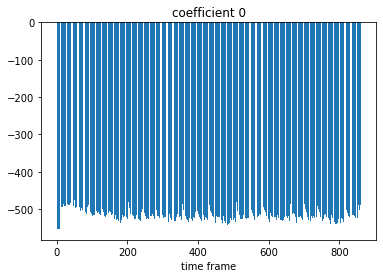

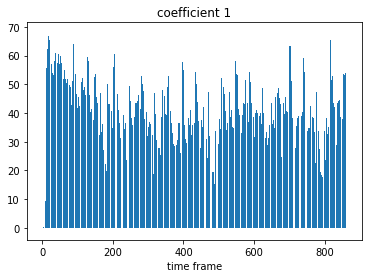

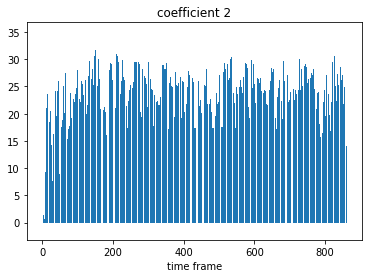

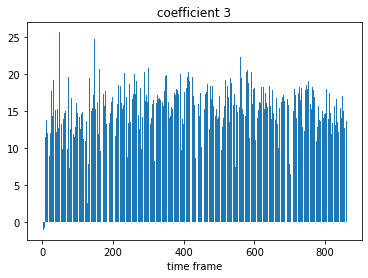

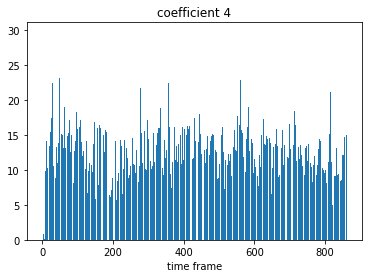

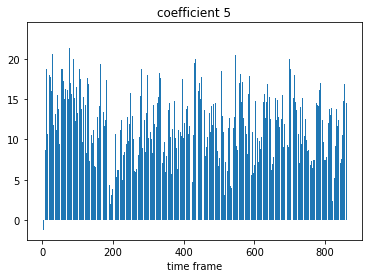

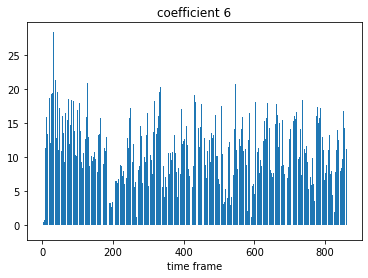

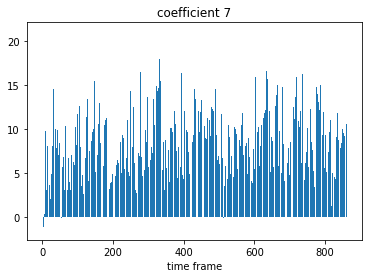

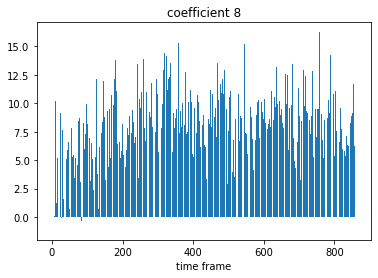

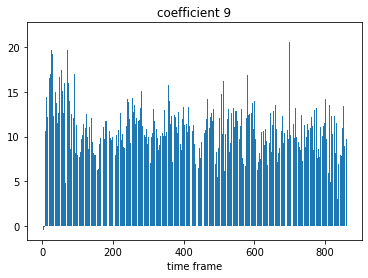

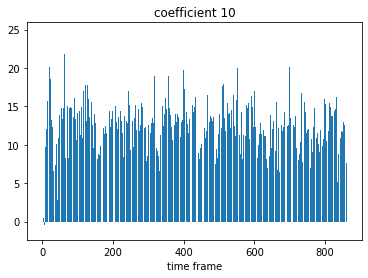

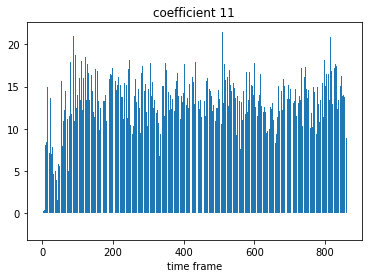

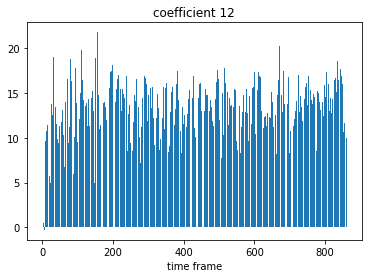

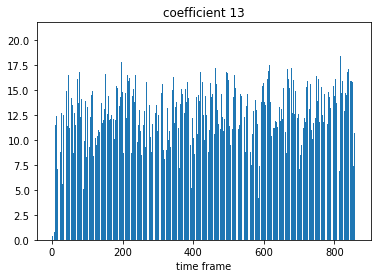

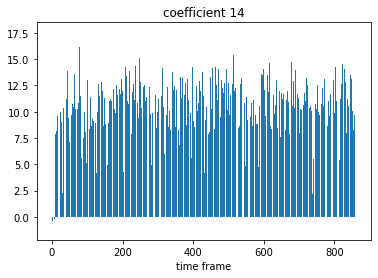

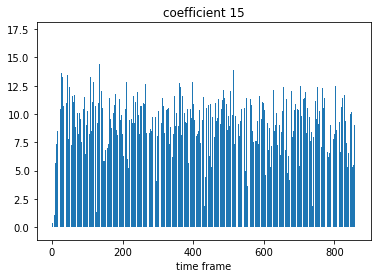

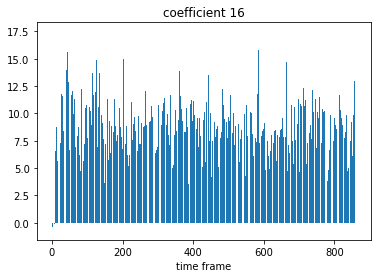

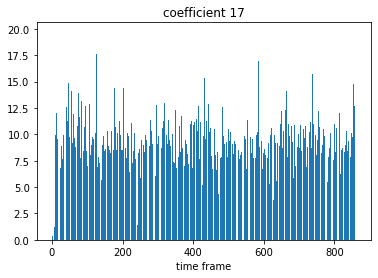

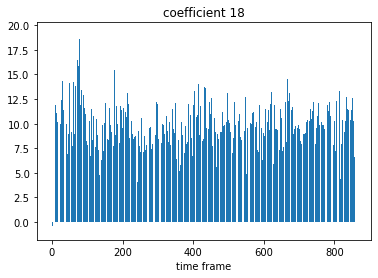

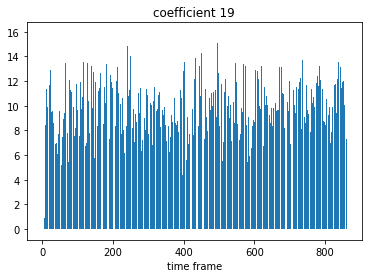

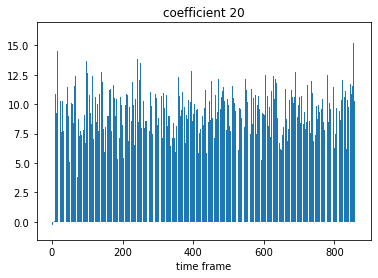

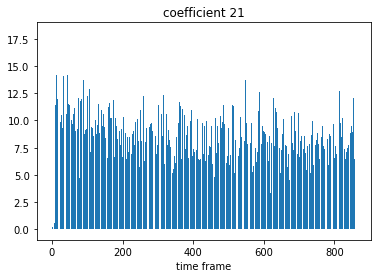

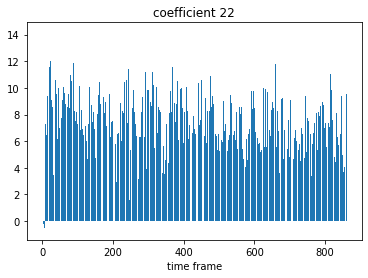

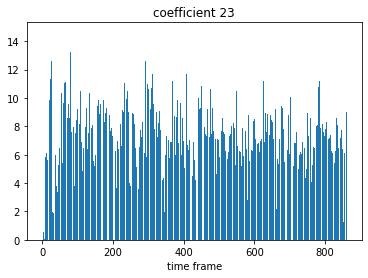

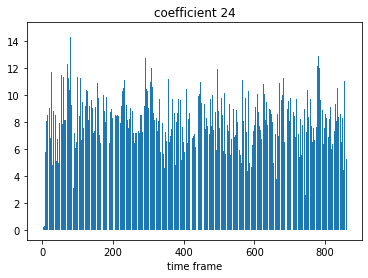

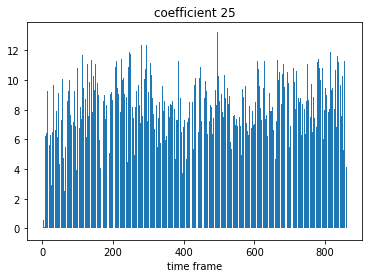

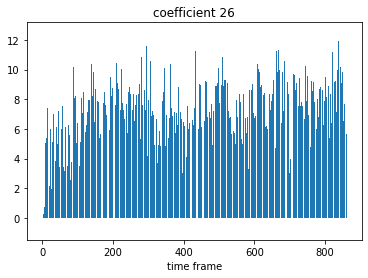

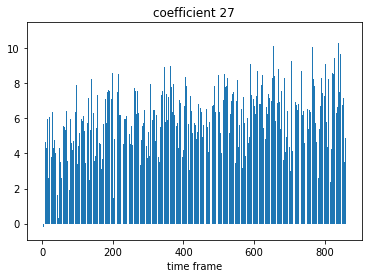

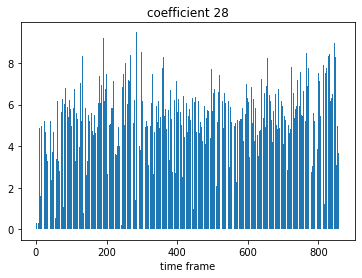

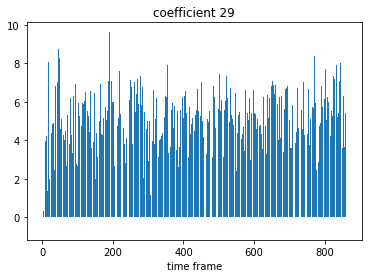

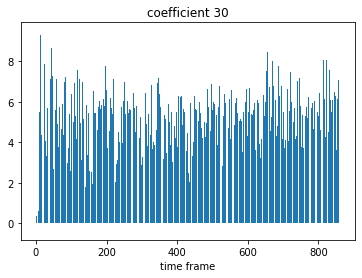

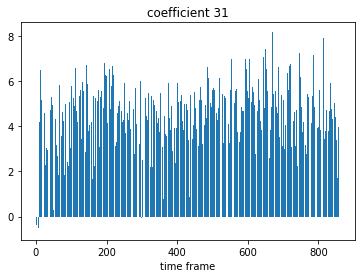

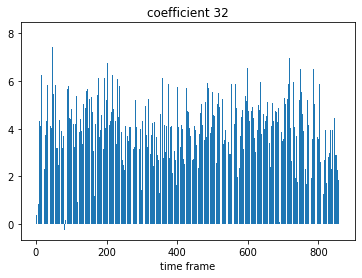

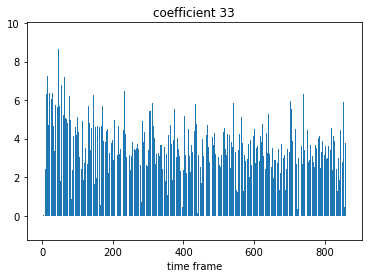

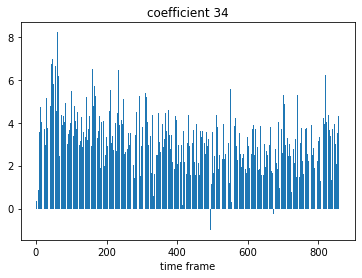

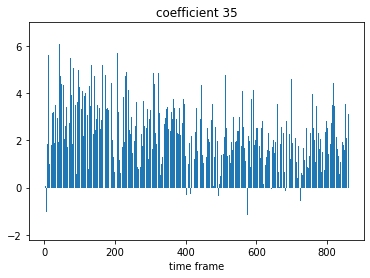

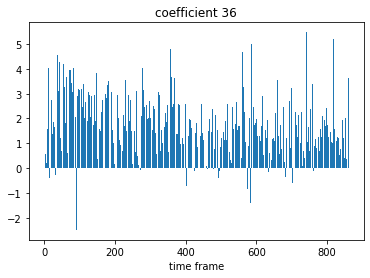

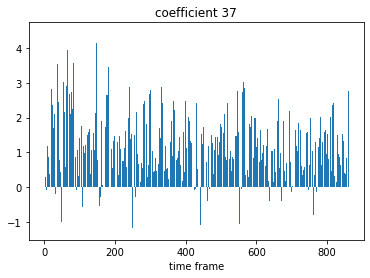

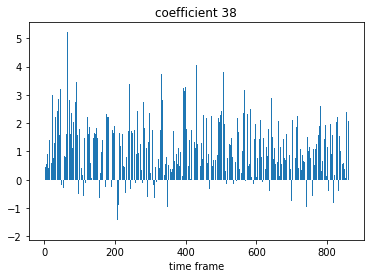

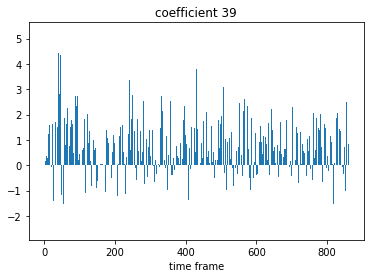

In [16]:
#display all coefs as bar plots over time
for coef in range(40):
    plt.bar(np.arange(len(mfcc[coef,:])),mfcc[coef,:], align='center', alpha=1)
    plt.xlabel('time frame')
    plt.title(f'coefficient {coef}')
    plt.show()

In [9]:
print(mfcc)

[[-4.9461169e+02 -4.9461169e+02 -4.9461169e+02 ... -4.3997195e+02
  -3.7460690e+02 -3.1077136e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  6.3098698e+01
   5.9465805e+01  5.2786240e+01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  4.2581482e+01
   4.6517700e+01  4.4687527e+01]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.2289658e-01
  -2.6429939e-01 -4.0494728e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.0269051e-01
   1.0120487e+00  6.7148972e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.3466072e+00
   8.9896774e-01  8.9342308e-01]]


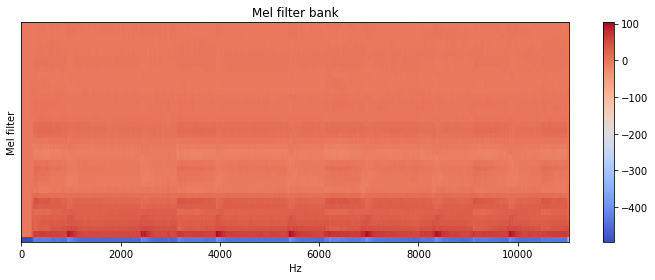

In [11]:
import librosa.display
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='linear')
plt.ylabel('Mel filter')
plt.title('Mel filter bank')
plt.colorbar()
plt.tight_layout()
plt.show()